# Network Analysis: Investigate Chennai Floods

* 👟 Ready To Run!
* 🔬 Data Science

__Requirements__
* 🗄️ Utility Service Configuration: Geocoding
* 🗄️ Utility Service Configuration: Hydrology

On December 1–2, 2015, the Indian city of Chennai received more rainfall in 24 hours than it had seen on any day since 1901. The deluge followed a month of persistent monsoon rains that were already well above normal for the Indian state of Tamil Nadu. At least 250 people had died, several hundred had been critically injured, and thousands had been affected or displaced by the flooding that ensued.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Network-Analysis:-Investigate-Chennai-floods" data-toc-modified-id="Network-Analysis:-Investigate-Chennai-floods-1">Network Analysis: Investigate Chennai floods</a></span><ul class="toc-item"><li><span><a href="#Summary-of-this-sample" data-toc-modified-id="Summary-of-this-sample-1.1">Summary of this sample</a></span></li><li><span><a href="#Chennai-Floods-Explained" data-toc-modified-id="Chennai-Floods-Explained-1.2">Chennai Floods Explained</a></span></li><li><span><a href="#How-much-rain-and-where?" data-toc-modified-id="How-much-rain-and-where?-1.3">How much rain and where?</a></span></li><li><span><a href="#Spatial-Analysis" data-toc-modified-id="Spatial-Analysis-1.4">Spatial Analysis</a></span></li><li><span><a href="#What-caused-the-flooding-in-Chennai?" data-toc-modified-id="What-caused-the-flooding-in-Chennai?-1.5">What caused the flooding in Chennai?</a></span><ul class="toc-item"><li><span><a href="#A-wrong-call-that-sank-Chennai" data-toc-modified-id="A-wrong-call-that-sank-Chennai-1.5.1">A wrong call that sank Chennai</a></span></li></ul></li><li><span><a href="#Flood-Relief-Camps" data-toc-modified-id="Flood-Relief-Camps-1.6">Flood Relief Camps</a></span><ul class="toc-item"><li><span><a href="#Routing-Emergency-Supplies-to-Relief-Camps" data-toc-modified-id="Routing-Emergency-Supplies-to-Relief-Camps-1.6.1">Routing Emergency Supplies to Relief Camps</a></span></li></ul></li></ul></li></ul></div>

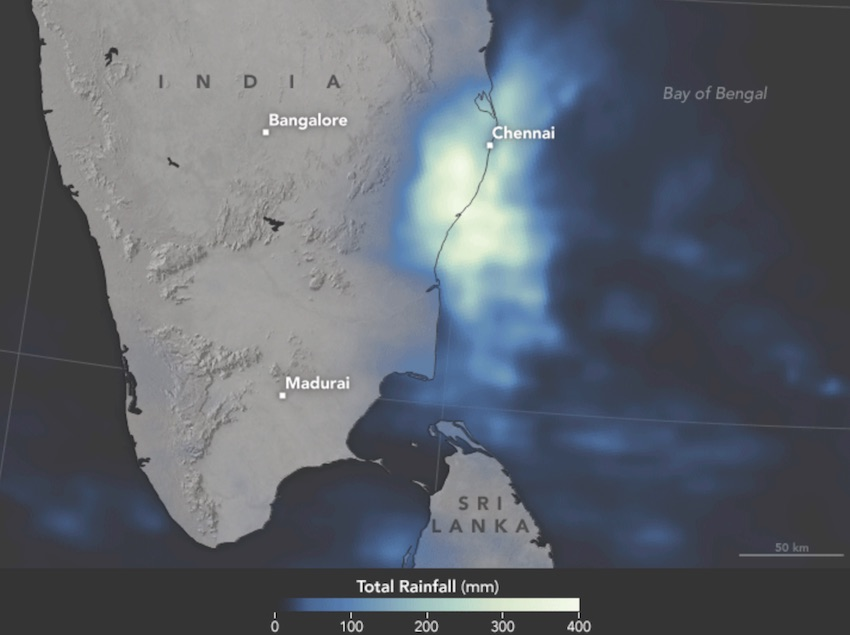

The image above provides satellite-based estimates of rainfall over southeastern India on December 1–2, accumulating in 30–minute intervals. The rainfall data is acquired from the Integrated Multi-Satellite Retrievals for GPM (IMERG), a product of the [Global Precipitation Measurement](http://www.nasa.gov/mission_pages/GPM/main/index.html) mission. The brightest shades on the map represent rainfall totals approaching 400 millimeters (16 inches) during the 48-hour period. These regional, remotely-sensed estimates may differ from the totals measured by ground-based weather stations. According to Hal Pierce, a scientist on the GPM team at NASA’s Goddard Space Flight Center, the highest rainfall totals exceeded 500 mm (20 inches) in an area just off the southeastern coast.

[Source: NASA http://earthobservatory.nasa.gov/IOTD/view.php?id=87131]

## Summary of this sample
This sample showcases not just the analysis and visualization capabilities of your GIS, but also the ability to store illustrative text, graphics and live code in a Jupyter notebook.

The sample starts off reporting the devastating effects of the flood. We plot the locations of rainfall guages and **interpolate** the data to create a continuous surface representing the amount of rainfall throughout the state.

Next, we plot the locations of major lakes and **trace downstream** the path floodwaters would take. We create a **buffer** around this path to show at-risk areas.

In the second part of the sample, we take a look at **time series** satellite imagery and observe the human impacts on natural reservoirs over a period of two decades.

We then vizualize the locations of relief camps and analyze their capacity using **pandas** and **matplotlib**. We **aggregate** the camps by district to understand which ones have the largest number of refugees.

In the last section, we perform a **routing** analysis to figure out the best path to route emergency supplies from storage to the relief camps.

First, let's import all the necessary libraries and connect to our GIS.

In [1]:
from datetime import datetime as dt
from IPython.display import YouTubeVideo

from arcgis.gis import GIS
from arcgis.geocoding import geocode
from arcgis import features

In [2]:
gis = GIS("home")


## Chennai Floods Explained

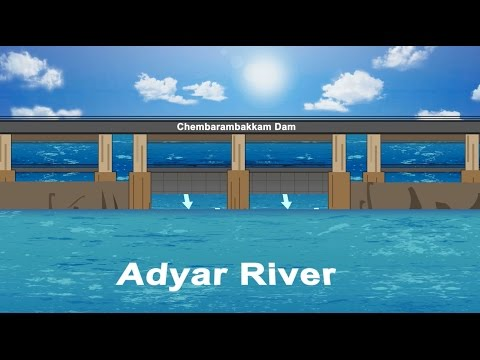

In [3]:
YouTubeVideo('x4dNIfx6HVs')

The catastrophic flooding in Chennai is the result of the heaviest rain in several decades, which forced authorities to release a massive 30,000 cusecs (cubic feet per second) from the Chembarambakkam reservoir into the Adyar river over two days. This caused the river to flood its banks and submerge neighborhoods on both sides. It did not help that the Adyar’s stream is not very deep or wide, and its banks have been heavily encroached upon over the years.
Similar flooding triggers were in action at Poondi and Puzhal reservoirs, and the Cooum river that winds its way through the city.
While Chief Minister J Jayalalithaa said that damage was “inevitable” during the earlier phase of heavy rain, the fact remains that the mindless development of Chennai over the last two decades — <b>the filling up of lowlands and choking of stormwater drains and other exits for water — has played a major part in the escalation of the crisis.</b>

[Source: Indian Express http://indianexpress.com/article/explained/why-is-chennai-under-water/#sthash.LlhnqM4B.dpuf]

## How much rain and where?

To get started with our analysis, we bring in a map of the affected region.

MapView(layout=Layout(height='400px', width='100%'))


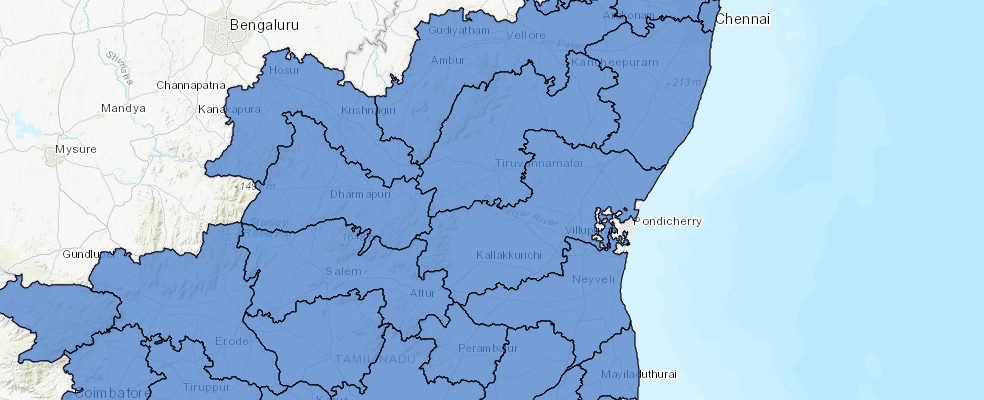

In [4]:
map_chennai = gis.map("Chennai")
map_chennai

We can search for content in our GIS and add layers to our map that can be used for visualization or analysis:

In [5]:
data_groups = gis.groups.search('"Esri Sample Notebooks Data" owner:esri_notebook',
                                outside_org=True)
group_query = f"group: {data_groups[0].id}" if data_groups else ""
chennai_waste = gis.content.search(f"Solid Waste Management {group_query}",
                                   item_type="feature service",
                                   outside_org=True)[0]
chennai_waste

<Item title:"solid_waste_management" type:Feature Layer Collection owner:esri_notebook>

In [6]:
map_chennai.content.add(chennai_waste)


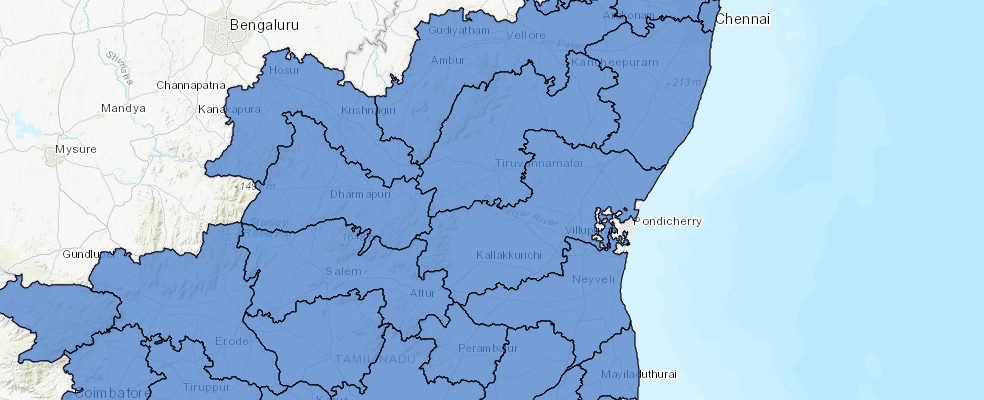

In [7]:
map_chennai.take_screenshot()

To get a sense of how much it rained and where, let's use rainfall data for December 2nd 2015, obtained from the Regional Meteorological Center in Chennai. Tabular data is hard to visualize, so let's bring in a map from our GIS to visualize the data:

In [8]:
rainfall = gis.content.search(f"Chennai_precipitation {group_query}",
                              item_type="feature service",
                              outside_org=True)[0]
rainfall

<Item title:"Chennai_precipitation" type:Feature Layer Collection owner:esri_notebook>

MapView(layout=Layout(height='400px', width='100%'))


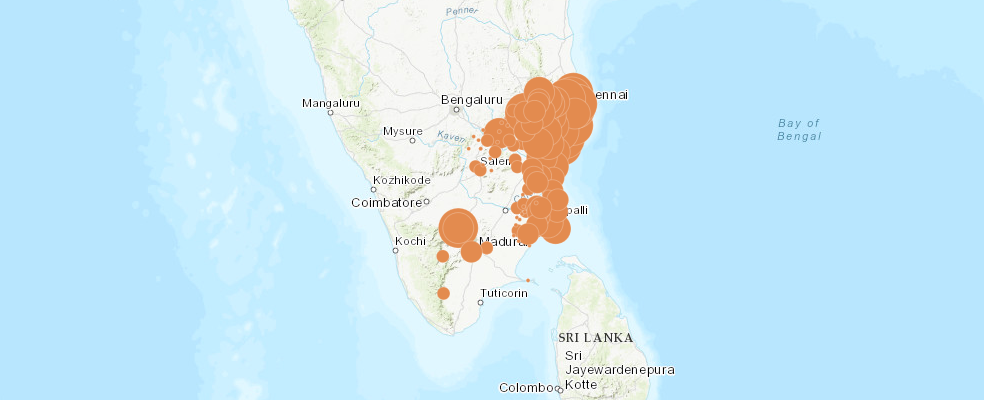

In [9]:
map_rainfall = gis.map("Tamil Nadu, India")
map_rainfall

We then add this layer to our map to see the locations of the weather stations from which the rainfall data was collected:

In [10]:
map_rainfall.content.add(rainfall, {"renderer": "ClassedSizeRenderer",
                                  "field_name": "RAINFALL"})


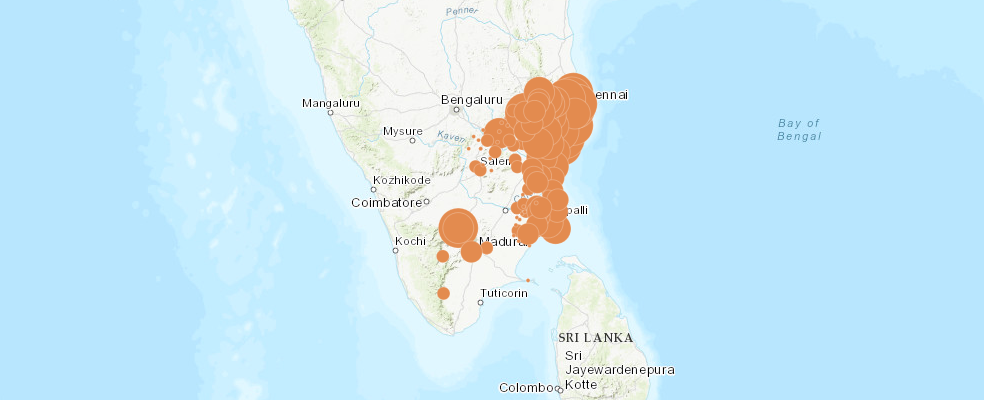

In [11]:
map_rainfall.take_screenshot()

Here we used the **smart mapping** capability of the GIS to automatically render the data with proportional symbols.

## Spatial Analysis
Rainfall is a continuous phenonmenon that affects the whole region, not just the locations of the weather stations. Based on the observed rainfall at the monitoring stations and their locations, we can interpolate and deduce the approximate rainfall across the whole region. We use the **Interpolate Points** tool from the GIS's spatial analysis service for this.

The Interpolate Points tool uses <a href="http://desktop.arcgis.com/en/desktop/latest/guide-books/extensions/geostatistical-analyst/what-is-empirical-bayesian-kriging-.htm">empirical Bayesian kriging</a> to perform the interpolation.

In [12]:
interpolated_rf = features.analyze_patterns.interpolate_points(
    rainfall, field='RAINFALL')

{"cost": 0.119}


Let us create another map of Tamil Nadu state and render the output from Interpolate Points tool

MapView(layout=Layout(height='400px', width='100%'))


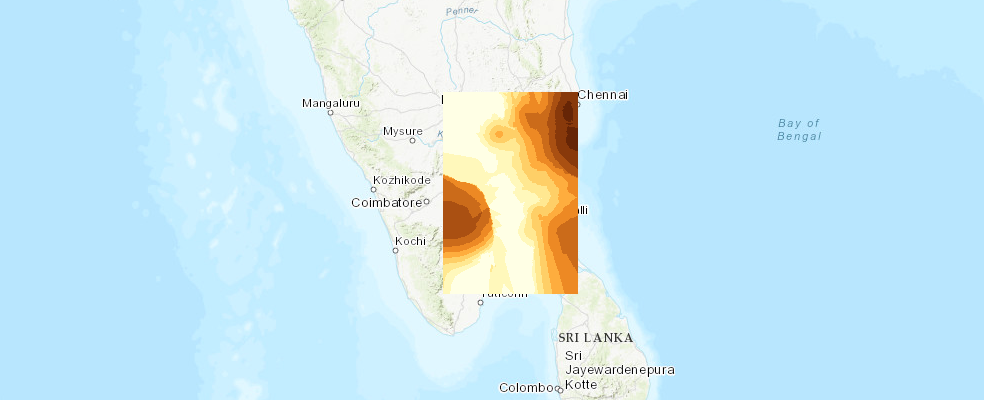

In [13]:
map_int = gis.map("Tamil Nadu")
map_int

In [14]:
map_int.content.add(interpolated_rf['result_layer'])


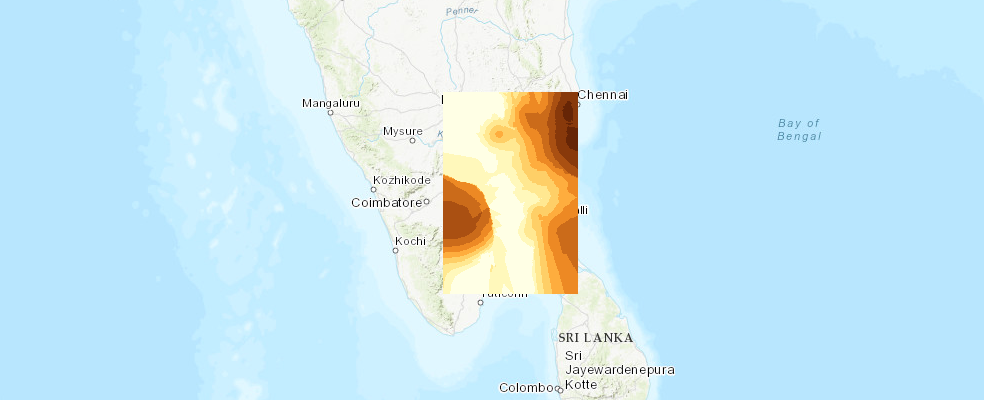

In [15]:
map_int.take_screenshot()

We see that rainfall was most severe in and around Chennai as well some parts of central Tamil Nadu.

## What caused the flooding in Chennai?

### A wrong call that sank Chennai
Much of the flooding and subsequent waterlogging was a consequence of the outflows from major reservoirs into swollen rivers and into the city following heavy rains. The <b>release of waters from the Chembarambakkam reservoir</b> in particular has received much attention. [Source: The Hindu, http://www.thehindu.com/news/cities/chennai/chennai-floods-a-wrong-call-that-sank-the-city/article7967371.ece]

MapView(layout=Layout(height='400px', width='100%'))


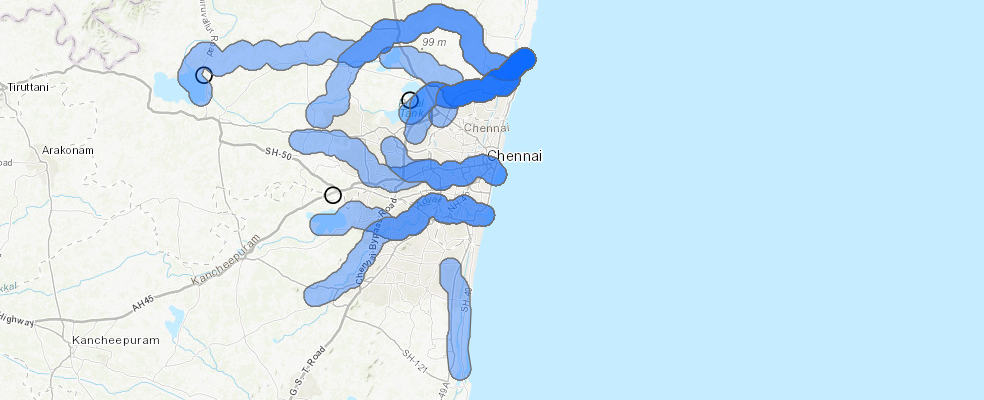

In [16]:
map_water = gis.map("Chennai")
map_water

Let's have a look at the major lakes and water reservoirs that were filled to the brim in Chennai due to the rains. We'll plot the locations of some of the reservoirs that had a large outflow during the rains.

To plot the locations, we use geocoding tools from the `tools` module. Your GIS can have more than one geocoding service, but for simplicity, the sample below chooses the first available geocoder to perform an address search.

In [17]:
map_water.content.draw(geocode("Chembarambakkam, Tamil Nadu")[0],
               {"title": "Chembarambakkam", "content": "Water reservoir"})
map_water.content.draw(geocode("Puzhal Lake, Tamil Nadu")[0],
               {"title": "Puzhal", "content": "Water reservoir"})
map_water.content.draw(geocode("Kannampettai, Tamil Nadu")[0],
               {"title": "Poondi Lake ", "content": "Water reservoir"})

To identify the flood prone areas, let's trace the path that the water would take when released from the lakes. To do this, we first bring in a layer of lakes in Chennai:

In [18]:
chennai_lakes = gis.content.search(f"chennai lakes {group_query}",
                                   item_type="feature service",
                                   outside_org=True)[0]
chennai_lakes

<Item title:"Chennai_lakes" type:Feature Layer Collection owner:esri_notebook>

Now, let's call the **`Trace Downstream`** analysis tool from the GIS:

In [19]:
downstream = features.find_locations.trace_downstream(chennai_lakes)
downstream.query()

{"cost": 0}


<FeatureSet> 11 features

The areas surrounding the trace paths are most prone to flooding and waterlogging. To identify the areas that were at risk, we buffer the traced flow paths by one mile in each direction and visualize it on the map. We see that large areas of the city of Chennai were susceptible to flooding and waterlogging.

In [20]:
floodprone_buffer = features.use_proximity.create_buffers(
    downstream, [1], units='Miles')

{"cost": 0.011}


In [21]:
map_water.content.add(floodprone_buffer)


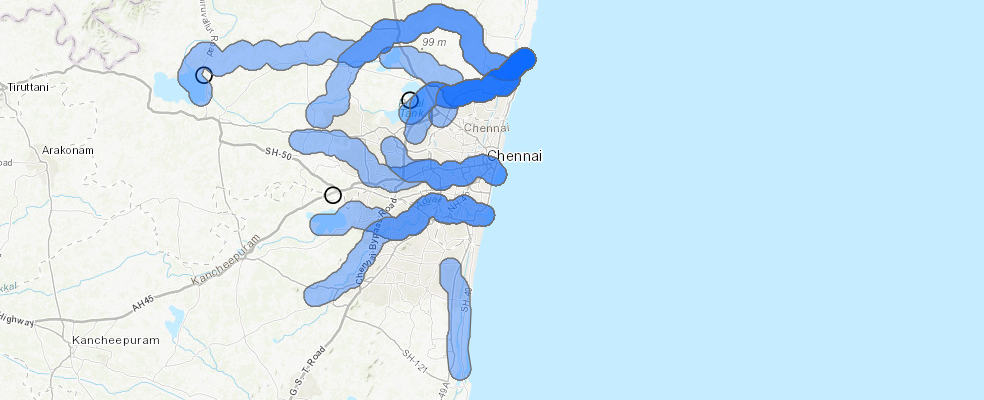

In [22]:
map_water.take_screenshot()

## Flood Relief Camps

To provide emergency assistance, the Tamil Nadu government has set up several flood relief camps in the flood affected areas. They provide food, shelter and the basic necessities to thousands of people displaced by the floods. The locations of the flood relief camps was obtained from http://cleanchennai.com/floodrelief/2015/12/09/relief-centers-as-on-8-dec-2015/ and published to the GIS as a layer, that is visualized below:

In [23]:
relief_centers = gis.content.search(
    f"Chennai Relief Centers {group_query}",
    item_type="Feature Service",
    outside_org=True)[0]

MapView(layout=Layout(height='400px', width='100%'))


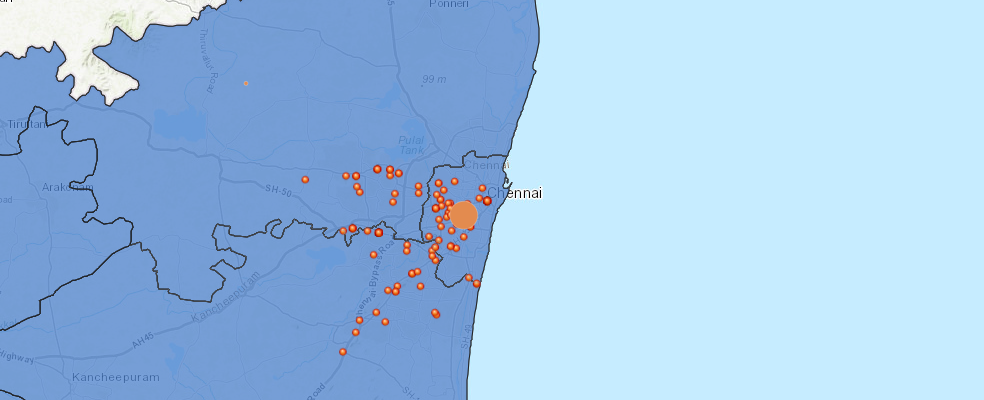

In [24]:
map_relief = gis.map("Chennai")
map_relief

In [25]:
map_relief.content.add(chennai_waste)

In [26]:
map_relief.content.add(relief_centers)

Let us read the relief center layer as a pandas dataframe to analyze the data further

In [27]:
relief_data = relief_centers.layers[0].query().sdf
relief_data.head()

FID  Sl_No_ Zone______  Division__  No_of_Cent  \
0    1       1          I          10          10   
1    2       2                      2           0   
2    3       3                      2           0   
3    4       4                      7           0   
4    5       5                      4           0   

                                  F_Locations  No_of_pers  No_of_fami  \
0                  Poonthotam School, Chennai         200          65   
1    St.Joseph church community Hall, Chennai         600         200   
2  Nehru Nagar chennai Middle school, Chennai         250          75   
3                  Kalaimagal School, Chennai          50          15   
4              Ramanathapuram School, Chennai         300         100   

                Contact_No SymbolID  \
0   Balamurali, 9445190311            
1    Jayakumar, 9445190302            
2    Jayakumar, 9445190302            
3    Shanmugam, 9445190301            
4  Rameshkumar, 9445190304            

                                               SHAPE  
0  {"x": 8919695.334199999, "y": 1464332.82629999...  
1  {"x": 8936283.704100002, "y": 1469202.8202, "s...  
2  {"x": 8916764.954599999, "y": 1450941.69069999...  
3  {"x": 8924034.069200002, "y": 1462457.79919999...  
4  {"x": 8919695.334199999, "y": 1464332.82629999...

In [28]:
relief_data.columns = relief_data.columns.str.lower()

In [29]:
relief_data['no_of_pers'].sum()

31478

In [30]:
relief_data['no_of_pers'].describe()

count         136.0
mean     231.455882
std      250.334202
min            10.0
25%            60.0
50%           150.0
75%           300.0
max          1500.0
Name: no_of_pers, dtype: Float64

<Axes: >

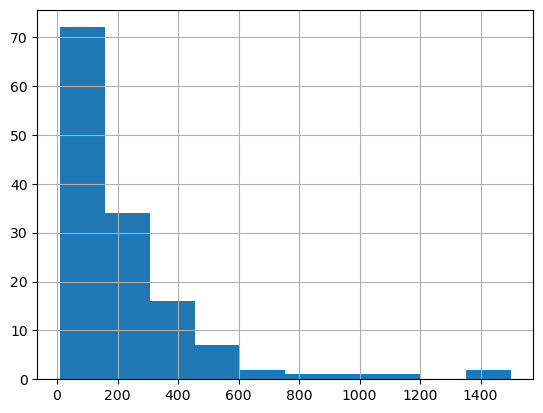

In [31]:
relief_data['no_of_pers'].hist()

In our dataset, each row represents a relief camp location. To quickly get the dimensions (rows & columns) of our data frame, we use the `shape` property.

In [32]:
relief_data.shape

(136, 11)

As of 8th December, 2015, there were 31,478 people in the 136 relief camps. Let's aggregate them by the district the camp is located in. To accomplish this, we use the `aggregate_points` tool.

In [33]:
chennai_waste_featurelayer = chennai_waste.layers[0]

In [34]:
res = features.summarize_data.aggregate_points(
    relief_centers,
    chennai_waste_featurelayer,
    False,
    ["no_of_pers Sum"])

{"cost": 0.168}


In [35]:
aggr_lyr = res['aggregated_layer']

In [36]:
map_relief.content.add(aggr_lyr, {"renderer": "ClassedSizeRenderer",
                                "field_name": "sum_no_of_pers"})


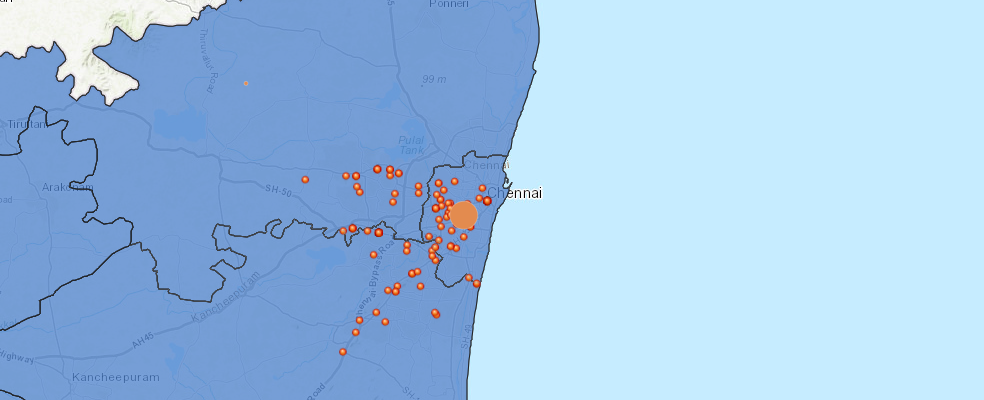

In [37]:
map_relief.take_screenshot()

In [38]:
df = aggr_lyr.query().sdf
df.head()

OBJECTID_1    district_n districtco  lcya_avail  lcya_balan  lcya_requi  \
0           9   Thiruvallur        602       18.18   42.790001   60.970001   
1          12       Chennai        603       22.48        25.0        30.0   
2          15  Kancheepuram        604       61.91   35.900002   55.900002   

   objectid  sb_dumper_  sb_other_s  sb_storage  ...  vasct_lorr  vasct_othe  \
0         9         200           3           0  ...          17           0   
1        23          36           0         177  ...           4           0   
2        26         181         150         100  ...          10           2   

   vasct_trac  year   Shape_Length         Shape_Area  sum_no_of_pers  \
0           3  2014  568880.362636  3587749935.884738          4063.0   
1           2  2014   72099.555032   185956515.160373         19045.0   
2           7  2014  425113.678101  4716386935.148334          8370.0   

   Point_Count  AnalysisArea  \
0           27   1304.702697   
1           64      67.72023   
2           45   1722.709824   

                                               SHAPE  
0  {"rings": [[[8927226.489100002, 1470373.014199...  
1  {"rings": [[[8927223.1496, 1470310.1543999985]...  
2  {"rings": [[[8914096.3552, 1464672.7712000012]...  

[3 rows x 33 columns]

Let's represent the aggregate result as a table:

In [39]:
df = aggr_lyr.query().sdf

df2 = df[['district_n', 'sum_no_of_pers']]
df2.set_index('district_n', inplace=True)
df2

sum_no_of_pers
district_n                  
Thiruvallur           4063.0
Chennai              19045.0
Kancheepuram          8370.0

<Axes: xlabel='district_n'>

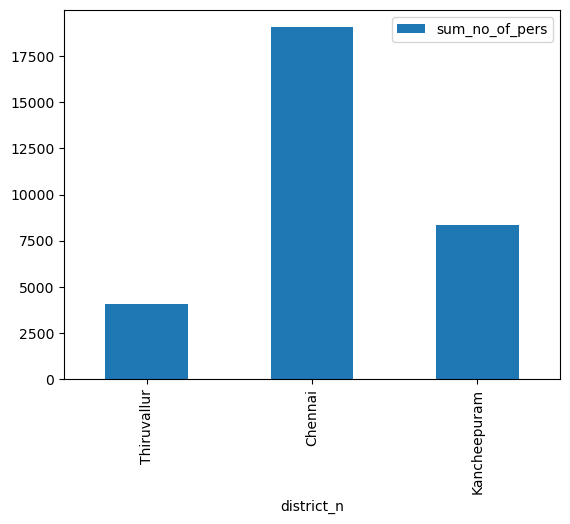

In [40]:
df2.plot(kind='bar')

### Routing Emergency Supplies to Relief Camps

A centralized location was established at Nehru Stadium to organize the relief materials collected from various organizations and volunteers. From there, the relief material was distributed to people affected by the flood.

ArcGIS routing tools can help plan routes for relief trucks from the center stadium to relief camps:

MapView(layout=Layout(height='400px', width='100%'))


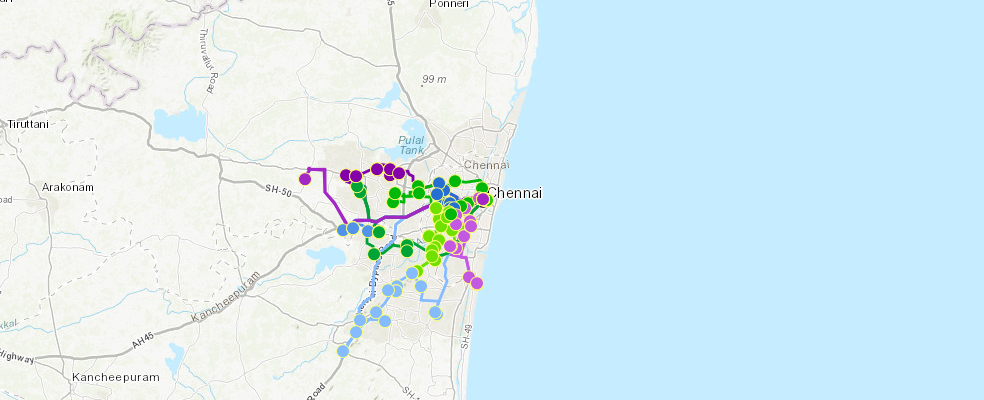

In [41]:
map_route = gis.map("Chennai")
map_route

In [42]:
nehru_stadium = geocode('Jawaharlal Nehru Stadium, Chennai',
                        max_locations=1,
                        as_featureset=True
                        )

map_route.content.add(nehru_stadium)

In [43]:
start_time = dt(2015, 12, 13, 9, 0)

In [44]:
routes = features.use_proximity.plan_routes(
    stops_layer=relief_centers,
    route_count=10,
    max_stops_per_route=15,
    route_start_time=start_time,
    start_layer=nehru_stadium.to_dict(),
    travel_mode='Driving Time',
    stop_service_time=30)

map_route.content.add(routes['routes_layer'])

Network elements with avoid-restrictions are traversed in the output (restriction attribute names: "Avoid Unpaved Roads" "Avoid Private Roads" "Through Traffic Prohibited" "Avoid Gates").
{"cost": 10.0}


In [45]:
map_route.content.add(routes['assigned_stops_layer'])


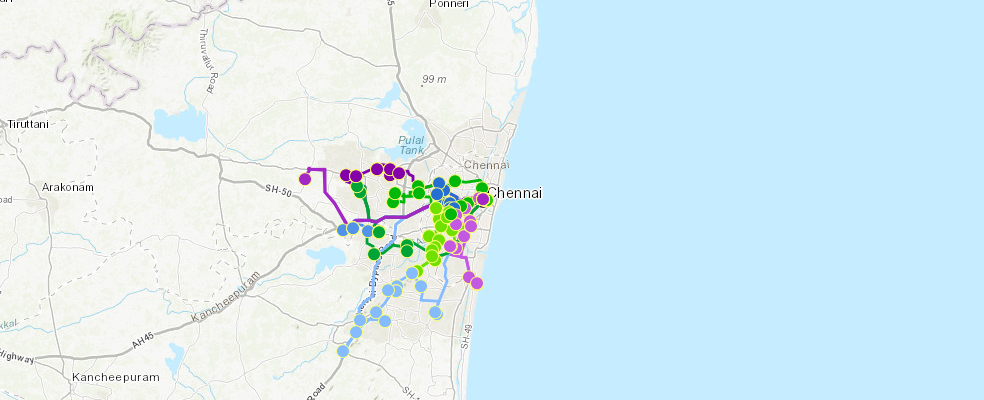

In [46]:
map_route.take_screenshot()

Once the routes have been generated, they can be given to drivers, and used to ensure that relief material is promptly delivered to those in need and help alleviate the suffering they are going through.